## 0. 메모리 청소

In [1]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [2]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
import matplotlib.pyplot as plt
import time
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. 복사

### 깊은 복사

In [3]:
original = [1, 2, 3]
copy_o = original
print("copy_o : ", copy_o)
print("original : ", original)

copy_o[2] = 10
print("copy_o : ", copy_o)
print("original : ", original)

copy_o :  [1, 2, 3]
original :  [1, 2, 3]
copy_o :  [1, 2, 10]
original :  [1, 2, 10]


### 얕은 복사

In [4]:
import copy

original = [[1, 2], 3]
copy_o = copy.copy(original)
print("copy_o : ", copy_o)
print("original : ", original)

copy_o[0] = 100
print("copy_o : ", copy_o)
print("original : ", original)

copy_o :  [[1, 2], 3]
original :  [[1, 2], 3]
copy_o :  [100, 3]
original :  [[1, 2], 3]


In [5]:
append = copy.copy(original)
append[0].append(4)
print("append : ", append)
print("original : ", original)

append :  [[1, 2, 4], 3]
original :  [[1, 2, 4], 3]


### 깊은 복사

In [6]:
import copy

original = [[1, 2], 3]
copy_o = copy.deepcopy(original)
print("copy_o : ", copy_o)
print("original : ", original)

copy_o[0] = 100
print("copy_o : ", copy_o)
print("original : ", original)

copy_o :  [[1, 2], 3]
original :  [[1, 2], 3]
copy_o :  [100, 3]
original :  [[1, 2], 3]


## 2. Self VGG Net

### 1) VGG Net 모델 정의

In [7]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

# All layer
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim)
        )
        
    def forward(self, x):
        x = self.features(x) # torch.Size([32, 512, 8, 8])
        x = self.avgpool(x) # torch.Size([32, 512, 7, 7])
        h = x.view(x.shape[0], -1) # torch.Size([32, 512*7*7])
        x = self.classifier(h) # torch.Size([32, 2])
        return x, h

# VGG layer
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3
    
    # VGG Net layer 구성
    for c in config:
        assert (c == 'M' or isinstance(c, int)) # assert : 조건이 True가 아니면 에러 발생 # isinstance : 변수의 자료형 판단하여 True인지 False인지 제공
        # Maxpooling layer 결합
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        # Convolution layer 결합
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            # 배치 정규화 적용 : 계층마다 변화하는 분포(학습 속도 저하, 학습 어려움 등의 문제) -> 계층마다 평균 0, 표준편차 1로 분포(학습 속도 향상, 학습 가능성 증가)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            # 배치 정규화 미적용
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            # 채널 업데이트
            in_channels = c
            
    return nn.Sequential(*layers)

### 2) VGG Net 모델 학습

In [8]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)
model_name = "vgg11_layers"
output_dim = 2
model = VGG(vgg11_layers, output_dim)

print("model : ", model)

model :  VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Max

## 3. Embedded VGG Net

In [9]:
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained=True)

print("pretrained_model : ", pretrained_model)

pretrained_model :  VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
  

## 4. 이미지 데이터 전처리

### 1) 이미지 변환

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)), # 이미지 크기 재조절
    transforms.RandomRotation(5), # 이미지 회전(5도 이하)
    transforms.RandomHorizontalFlip(0.5), # 이미지 좌우 대칭(50% 확률)
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

### 2) 이미지 데이터셋 불러오기 + 이미지 변환

In [11]:
train_path = 'C:\\Users\\Bang\\JupyterProjects\\RetinaProject\\DeepLearningPytorchExample\\data\\Retina_Some_binary\\train'
test_path = 'C:\\Users\\Bang\\JupyterProjects\\RetinaProject\\DeepLearningPytorchExample\\data\\Retina_Some_binary\\test'

train_dataset = torchvision.datasets.ImageFolder(
    train_path, 
    transform = train_transforms
)
test_dataset = torchvision.datasets.ImageFolder(
    test_path, 
    transform = test_transforms
)

print("len(train_dataset) : ", len(train_dataset))
print("len(test_dataset) : ", len(test_dataset))

len(train_dataset) :  4532
len(test_dataset) :  1132


### 3) 훈련, 검증 데이터 분할 + 검증 이미지 재변환

In [12]:
valid_ratio = 0.8
n_train_examples = int(len(train_dataset) * valid_ratio)
n_valid_examples = len(train_dataset) - n_train_examples

splited_train_dataset, splited_valid_dataset = data.random_split(train_dataset, [n_train_examples, n_valid_examples]) # 훈련 데이터셋, 검증 데이터셋 크기 결정

In [13]:
splited_valid_dataset = copy.deepcopy(splited_valid_dataset)
splited_valid_dataset.dataset.transform = test_transforms

print(f"Number of training examples : {len(splited_train_dataset)}")
print(f"Number of validation examples : {len(splited_valid_dataset)}")
print(f"Number of testing examples : {len(test_dataset)}")

Number of training examples : 3625
Number of validation examples : 907
Number of testing examples : 1132


### 4) 데이터 로드 to 메모리

In [14]:
batch_size = 32
train_iterator = data.DataLoader(splited_train_dataset,
                                shuffle = True,
                                batch_size = batch_size
                                )
valid_iterator = data.DataLoader(splited_valid_dataset,
                                batch_size = batch_size
                                )
test_iterator = data.DataLoader(test_dataset,
                                batch_size = batch_size
                                )

## 5. 모델 정의

### 1) 옵티마이저, 손실함수 정의

In [15]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

### 2) 측정 함수 정의

In [16]:
# 정확도 측정 함수
def calculate_accuracy(y_pred, y): # ???
    top_pred = y_pred.argmax(1, keepdim = True)
    # print("top_pred : ", top_pred)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    # print("correct : ", correct)
    acc = correct.float() / y.shape[0]
    # print("acc : ", acc)
    return acc

### 3) 학습 함수 정의

In [17]:
# 모델 학습
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        
        # optimzier 초기화
        optimizer.zero_grad()
        
        # 모델 예측
        y_pred, _ = model(x)
        
        # loss, acc 계산
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        
        # loss, optimzier 업데이트
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() # ???
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator) # ???

# 모델 평가
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    
    # 모델 평가
    model.eval()
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device) # ???
            y = y.to(device)
            
            # optimzier 초기화
            optimizer.zero_grad()

            # 모델 예측
            y_pred, _ = model(x)

            # loss, acc 계산
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item() # ???
            # print("loss.item() : ", loss.item())
            epoch_acc += acc.item()
            # print("acc.item() : ", acc.item())
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator) # ???

# 모델 학습 소요시간
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs

## 6. 모델 학습

In [18]:
epochs = 100
best_valid_loss = float('inf')

# 에포크 반복
for epoch in range(epochs):
    # 모델 학습 소요시간
    start_time = time.monotonic()
    
    # 모델 학습
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    # 최적 loss의 model 저장
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'C:\\Users\\Bang\\JupyterProjects\\RetinaProject\\DeepLearningPytorchExample\\best_valid_model\\{model_name}.pt')
    
    # 모델 학습 소요시간
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 51s
	 Train Loss: 0.697 | Train Acc: 51.11%
	 Valid Loss: 0.694 | Valid Acc: 50.25%
Epoch: 02 | Epoch Time: 0m 47s
	 Train Loss: 0.688 | Train Acc: 55.70%
	 Valid Loss: 0.693 | Valid Acc: 52.10%
Epoch: 03 | Epoch Time: 0m 46s
	 Train Loss: 0.687 | Train Acc: 55.41%
	 Valid Loss: 0.692 | Valid Acc: 53.37%
Epoch: 04 | Epoch Time: 0m 45s
	 Train Loss: 0.684 | Train Acc: 57.29%
	 Valid Loss: 0.691 | Valid Acc: 52.84%
Epoch: 05 | Epoch Time: 0m 46s
	 Train Loss: 0.682 | Train Acc: 57.63%
	 Valid Loss: 0.691 | Valid Acc: 53.38%
Epoch: 06 | Epoch Time: 0m 46s
	 Train Loss: 0.680 | Train Acc: 57.47%
	 Valid Loss: 0.689 | Valid Acc: 52.84%
Epoch: 07 | Epoch Time: 0m 46s
	 Train Loss: 0.679 | Train Acc: 57.60%
	 Valid Loss: 0.688 | Valid Acc: 55.00%
Epoch: 08 | Epoch Time: 0m 45s
	 Train Loss: 0.676 | Train Acc: 58.15%
	 Valid Loss: 0.689 | Valid Acc: 53.16%
Epoch: 09 | Epoch Time: 0m 46s
	 Train Loss: 0.675 | Train Acc: 57.90%
	 Valid Loss: 0.688 | Valid Acc: 55.85%
E

Epoch: 75 | Epoch Time: 0m 44s
	 Train Loss: 0.622 | Train Acc: 66.84%
	 Valid Loss: 0.680 | Valid Acc: 56.19%
Epoch: 76 | Epoch Time: 0m 44s
	 Train Loss: 0.621 | Train Acc: 66.44%
	 Valid Loss: 0.685 | Valid Acc: 57.69%
Epoch: 77 | Epoch Time: 0m 44s
	 Train Loss: 0.620 | Train Acc: 66.52%
	 Valid Loss: 0.679 | Valid Acc: 57.16%
Epoch: 78 | Epoch Time: 0m 44s
	 Train Loss: 0.620 | Train Acc: 67.01%
	 Valid Loss: 0.680 | Valid Acc: 56.50%
Epoch: 79 | Epoch Time: 0m 44s
	 Train Loss: 0.620 | Train Acc: 66.73%
	 Valid Loss: 0.681 | Valid Acc: 56.94%
Epoch: 80 | Epoch Time: 0m 44s
	 Train Loss: 0.618 | Train Acc: 67.08%
	 Valid Loss: 0.680 | Valid Acc: 57.26%
Epoch: 81 | Epoch Time: 0m 44s
	 Train Loss: 0.617 | Train Acc: 67.38%
	 Valid Loss: 0.684 | Valid Acc: 57.58%
Epoch: 82 | Epoch Time: 0m 45s
	 Train Loss: 0.617 | Train Acc: 66.91%
	 Valid Loss: 0.679 | Valid Acc: 56.08%
Epoch: 83 | Epoch Time: 0m 44s
	 Train Loss: 0.617 | Train Acc: 66.79%
	 Valid Loss: 0.680 | Valid Acc: 56.30%
E

## 7. 모델 성능 측정

In [19]:
# 학습된 모델 불러오기
model.load_state_dict(torch.load(f"C:\\Users\\Bang\\JupyterProjects\\RetinaProject\\DeepLearningPytorchExample\\trained_model\\{model_name}.pt"))

# 모델 성능 측정
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'\t Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	 Test Loss: 0.653 | Test Acc: 61.00%


## 8. 모델 예측 확인

### 1) 모델 예측 함수 

In [20]:
def get_predictions(model, iterator):
    # 모델 평가
    model.eval()
    
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            
            # 모델 예측
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1) # ???
            top_pred = y_prob.argmax(1, keepdim = True) # 각 열에서 가장 큰 행 index 찾음. 출력 텐서를 입력과 동일한 크기로 유지
            
            # 모델 예측값 저장
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
            
    images = torch.cat(images, dim = 0) # 행 방향으로 합치기
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    
    return images, labels, probs

### 2) 정확하게 예측한 값 추출

In [21]:
# 정답 비교
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)

correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))
        
correct_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values) # reverse=True : 내림차순 정렬, key : key값을 활용한 정렬(기본값은 오름차순), torch.max(x, dim=0) : 행을 기준으로 최댓값을 가져온다

### 3) 이미지 출력을 위한 전처리

In [22]:
def normalize_image(image):
    # 이미지 최소값, 최대값 추출
    image_min = image.min()
    image_max = image.max()
    
    # 이미지 최소값, 최대값 지정 : 설정 최소값 이하 -> 설정 최소값으로 변경, 설정 최대값 이상 -> 설정 최대값으로 변경
    image.clamp_(min = image_min, max = image_max) # ???
    image.add_(-image_min).div_(image_max - image_min + 1e-5) # ???
    
    return image

In [23]:
def plot_most_correct(correct, classes, n_images, normalize=True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (25, 20))
    for i in range(rows * cols):
        # subplot 생성
        ax = fig.add_subplot(rows, cols, i + 1)
        
        # 옳은 example 이미지, label, 확률 추출 + 차원 순서 변경
        image, true_label, probs = correct[i]
        print(image.shape)
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label] # ???
        correct_prob, correct_label = torch.max(probs, dim = 0) # ???
        true_class = classes[true_label] # ???
        correct_class = classes[correct_label] # ???
        
        if normalize:
            image = normalize_image(image)
            
        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label : {true_class} ({true_prob:.3f})\n' \
                     f'pred label : {correct_class} ({correct_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


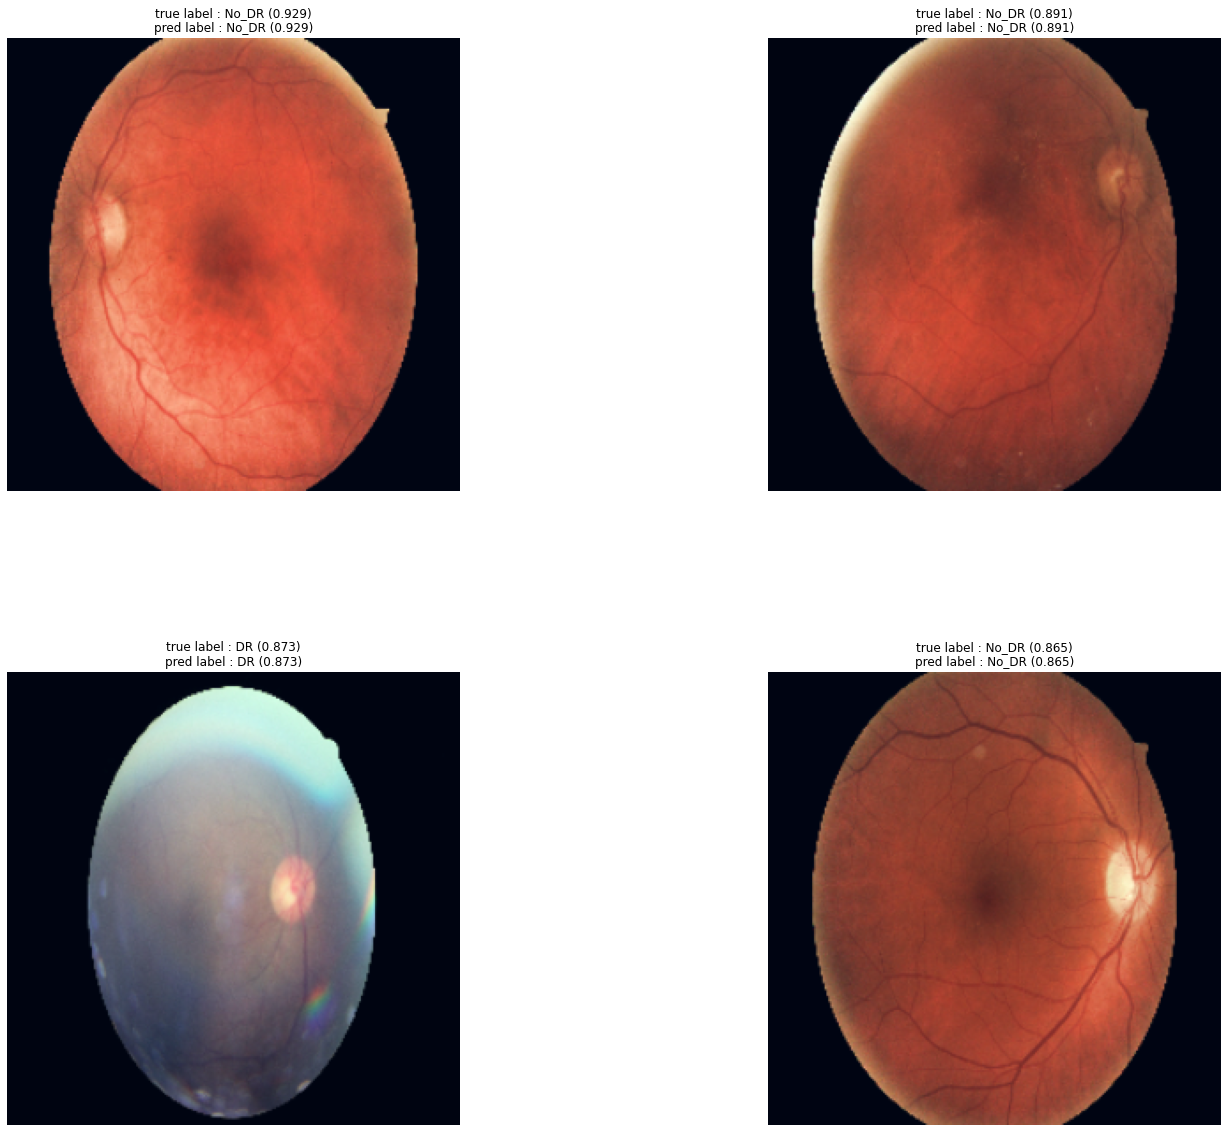

In [24]:
classes = test_dataset.classes
n_images = 5
plot_most_correct(correct_examples, classes, n_images)